---
title: "Lab 6: Variable Selection and Regularization"
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
author: James Compagno
jupyter: python3
---

In [247]:
import pandas as pd
import numpy as np
import plotnine as p9
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

# Dataset: Baseball Players

In this lab, we will use predictive modeling to design a model that predicts a baseball player's salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

**Format:** A data frame with 322 observations of major league players on the following 20 variables.

`AtBat` Number of times at bat in 1986 

`Hits` Number of hits in 1986 

`HmRun` Number of home runs in 1986

`Runs` Number of runs in 1986 

`RBI` Number of runs batted in in 1986 

`Walks` Number of walks in 1986 

`Years` Number of years in the major leagues 

`CAtBat` Number of times at bat during his career 

`CHits` Number of hits during his career 

`CHmRun` Number of home runs during his career 

`CRuns` Number of runs during his career 

`CRBI` Number of runs batted in during his career 

`CWalks` Number of walks during his career 

`League` A factor with levels A and N indicating player's league at the end of 1986 

`Division` A factor with levels E and W indicating player's division at the end of 1986 

`PutOuts` Number of put outs in 1986 

`Assists` Number of assists in 1986 

`Errors` Number of errors in 1986 

`Salary` 1987 annual salary on opening day in thousands of dollars 

`NewLeague` A factor with levels A and N indicating player's league at the beginning of 1987

You can download the dataset from [here](https://www.dropbox.com/s/boshaqfgdjiaxh4/Hitters.csv?dl=1).

A couple notes about this lab:

1.  Although it isn't listed as a specific question, don't forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

2.  There are a **lot** of variables in the dataset! You may want to use the `remainder = "passthrough"` trick in your column transformers, rather than typing out a ton of gene names.

3.  Don't forget that in penalized regression, we **must** standardize our numeric variables.

4.  There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.


In [248]:
# Read the data
hitters = pd.read_csv("Hitters.csv")

# Remove rows with no value for salary 
hitters = hitters.dropna(subset=["Salary"])
hitters = hitters.reset_index(drop=True)

# Assign values
X = hitters.drop(columns=["Salary"])
y = hitters["Salary"]

# Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

# Model Library 
model_library = {}
records = []

In [249]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
3,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [250]:
# Column Transformer 
ct = ColumnTransformer(
    [
        ("standardize", 
         StandardScaler(), 
         make_column_selector(dtype_include=np.number)),
        ("cat", 
         OneHotEncoder(drop="first", sparse_output=False), 
         make_column_selector(dtype_include=object))
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Part I: Different Model Specs

## A. Regression without regularization

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary linear regression

2.  Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3.  Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [251]:
# # Model Name
# model_name = "All_Features"
# regression_type = "Linear"  

# # Cross Validation Pipeline
# pipe = Pipeline([
#     ("preprocess", ct),
#     ("linear_regression", LinearRegression())
# ])

# # Add to Library
# model_library[model_name] = pipe.fit(X, y)

# # Metrics Calculation 
# rmse = cross_val_score(pipe, X, y, cv=5, scoring='neg_root_mean_squared_error')
# mse = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
# r2 = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# # Metrics Storage 
# records.append({
#     "Model": model_name,
#     "Regression Type": regression_type,
#     "Best Alpha": "NA", 
#     "Best L1 Ratio": "NA", 
#     "Split": "CV-5",
#     "RMSE Mean": -rmse.mean(),
#     "MSE Mean": -mse.mean(),
#     "R2 Mean": r2.mean()
# })

# # Display
# cumulative_models = (pd.DataFrame(records))
# cumulative_models

In [252]:
def run_linear_regression(model_name, features=None):
    """
    model_name - will be stored in model_library
    features - list or None
    Returns: DataFrame 
    """
    regression_type = "Linear"
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Cross Validation Pipeline
    pipe = Pipeline([
        ("preprocess", ct),
        ("linear_regression", LinearRegression())
    ])
    
    # Fit and add to Library
    pipe.fit(X_subset, y)
    model_library[model_name] = pipe
    
    # Get top 10 coefficients
    feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
    coefficients = pipe.named_steps['linear_regression'].coef_
    
    coef_df = pd.DataFrame({
        'Variable': feature_names,
        'Coefficient': coefficients
    }).sort_values('Coefficient', key=abs, ascending=False).head(10)
    
    # Metrics Calculation 
    rmse = cross_val_score(pipe, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(pipe, X_subset, y, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(pipe, X_subset, y, cv=5, scoring='r2')
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Best Alpha": "NA", 
        "Best L1 Ratio": "NA",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
        "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean()
    })
    
    # Display
    cumulative_models = pd.DataFrame(records)
    return cumulative_models

In [253]:
run_linear_regression("All_Features_Linear", None)

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495


Interpretation: The top Coefficients for salary: CRuns (Career Runs), CAtBat (Career At-Bats), Hits (1986 Hits), etc. are what you would expec: more time playing = more mony. However some coefficients are negative, likely due to multicollinearity as a person who has more bats will have more hits who will have more runs. 

## B. Ridge regression

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression

2.  Use cross-validation to **tune** the $\lambda$ hyperparameter.

3.  Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [256]:
def run_ridge_regression(model_name, features=None):
    """
    model_name - will be stored in model_library
    features - list or None
    Returns: DataFrame 
    """
    regression_type = "Ridge"
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with Ridge
    pipe = Pipeline([
        ("preprocess", ct),
        ("ridge", Ridge())
    ])
    
    # GridSearchCV 
    param_grid = {'ridge__alpha': np.logspace(-1, 2, 50)}
    gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
    gscv.fit(X_subset, y)
    
    # Add best model to Library
    model_library[model_name] = gscv.best_estimator_
    
    # Get best alpha
    best_alpha = gscv.best_params_['ridge__alpha']
    
    # Get top 10 coefficients
    coef_df = pd.DataFrame({
        'Variable': gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out(),
        'Coefficient': gscv.best_estimator_.named_steps['ridge'].coef_
    }).sort_values('Coefficient', key=abs, ascending=False).head(10)
    
    # Store coefficients in model library
    model_library[f"{model_name}_coefficients"] = coef_df
    
    # Metrics Calculation using best model
    rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Best Alpha": best_alpha, 
        "Best L1 Ratio": "NA",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
        "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean()
    })
    
    # Display
    cumulative_models = pd.DataFrame(records)
    return cumulative_models

In [257]:
run_ridge_regression("Ridge_All_Tuned", None)

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510


Interpretation: The coefficients for ridge regression were very similar to normal linear but in a different order and the coefficient number are smaller.. There is still an issue with multicollinearity 

## C. Lasso Regression

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression

2.  Use cross-validation to **tune** the $\lambda$ hyperparameter.

3.  Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [260]:
def run_lasso_regression(model_name, features=None):
    """
    model_name - will be stored in model_library
    features - list or None
    Returns: DataFrame 
    """
    regression_type = "Lasso"
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with Lasso
    pipe = Pipeline([
        ("preprocess", ct),
        ("lasso", Lasso())
    ])
    
    # GridSearchCV to tune alpha
    param_grid = {'lasso__alpha': np.logspace(-1, 2, 50)}
    gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
    gscv.fit(X_subset, y)
    
    # Add best model to Library
    model_library[model_name] = gscv.best_estimator_
    
    # Get best alpha
    best_alpha = gscv.best_params_['lasso__alpha']
    
    # Get top 10 coefficients
    coef_df = pd.DataFrame({
        'Variable': gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out(),
        'Coefficient': gscv.best_estimator_.named_steps['lasso'].coef_
    }).sort_values('Coefficient', key=abs, ascending=False).head(10)
    
    # Store coefficients in model library
    model_library[f"{model_name}_coefficients"] = coef_df
    
    # Metrics Calculation using best model
    rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Best Alpha": best_alpha, 
        "Best L1 Ratio": "NA",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
        "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean()
    })
    
    # Display
    cumulative_models = pd.DataFrame(records)
    return cumulative_models

In [261]:
run_lasso_regression("Lasso_All_Tuned", None)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.977e+04, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.719e+05, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+05, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coor

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623


## D. Elastic Net

1.  Create a pipeline that includes *all* the columns as predictors for `Salary`, and performs ordinary ridge regression

2.  Use cross-validation to **tune** the $\lambda$ and $\alpha$ hyperparameters.

3.  Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4.  Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [264]:
def run_elasticnet_regression(model_name, features=None):
    """
    model_name - will be stored in model_library
    features - list or None
    Returns: DataFrame 
    """
    regression_type = "ElasticNet"
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with ElasticNet
    pipe = Pipeline([
        ("preprocess", ct),
        ("elasticnet", ElasticNet())
    ])
    
    # GridSearchCV to tune alpha and l1_ratio
    param_grid = {
        'elasticnet__alpha': np.logspace(-1, 2, 50),
        'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
    }
    gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
    gscv.fit(X_subset, y)
    
    # Add best model to Library
    model_library[model_name] = gscv.best_estimator_
    
    # Get best hyperparameters
    best_alpha = gscv.best_params_['elasticnet__alpha']
    best_l1_ratio = gscv.best_params_['elasticnet__l1_ratio']
    
    # Get top 10 coefficients
    coef_df = pd.DataFrame({
        'Variable': gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out(),
        'Coefficient': gscv.best_estimator_.named_steps['elasticnet'].coef_
    }).sort_values('Coefficient', key=abs, ascending=False).head(10)
    
    # Store coefficients in model library
    model_library[f"{model_name}_coefficients"] = coef_df
    
    # Metrics Calculation using best model
    rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
    mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
    r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')
    
    # Metrics Storage 
    records.append({
        "Model": model_name,
        "Regression Type": regression_type,
        "Best Alpha": best_alpha, 
        "Best L1 Ratio": best_l1_ratio,
        "Variables Used": len(X_subset.columns) if features else "All",
        "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
        "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
        "Split": "CV-5",
        "RMSE Mean": -rmse.mean(),
        "MSE Mean": -mse.mean(),
        "R2 Mean": r2.mean()
    })
    
    # Display
    cumulative_models = pd.DataFrame(records)
    return cumulative_models

In [265]:
run_elasticnet_regression("ElasticNet_All_Tuned",None)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaco

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784


# Part II. Variable Selection

Based on the above results, decide on:

-   Which *numeric* variable is most important: 

        Hits

-   Which *five* numeric variables are most important:

        1. CRuns
        2. Hits
        3. AtBat
        4. CRBI
        5. CWalks

-   Which *categorical* variable is most important: 
        
        Division_W

For **each** of the four model specifications, compare the following possible feature sets:

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: $\lambda$ and $\alpha$ must be re-tuned for each feature set.)

## 1.  Using only the one best numeric variable.

In [266]:
run_linear_regression("Hits_Linear", features=['Hits'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213


In [267]:
run_ridge_regression("Hits_Ridge", features=['Hits'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410


In [268]:
run_lasso_regression("Hits_Lasso", features=['Hits'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640


In [269]:
run_elasticnet_regression("Hits_Elasticnet", features=['Hits'])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaco

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863


### Interpretation 

They were all roughly the same but Elastcicnet did the best in the MSE department 

## 2.  Using only the five best variables.

In [270]:
run_linear_regression("Top5_Linear", features=['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326


In [271]:
run_ridge_regression("Top5_Ridge", features=['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


In [272]:
run_lasso_regression("Top5_Lasso", features=['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks'])

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


In [273]:
run_elasticnet_regression("Top5_Elasticnet", features=['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks'])


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaco

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


### Interpretation 

In this case Ridge took the lead but not by much all the MSEs are not too different between the models 

## 3.  Using the five best numeric variables *and* their interactions with the one best categorical variable.

### Linear Model

In [274]:
# Model Name
model_name = "Lin_Num_Cat_Interact"
regression_type = "Linear"  

# Features
numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks']
cat_var = 'Division'

# Select and Subset
X_subset = X[numeric_vars + [cat_var]].copy()
X_subset['Division_Binary'] = (X_subset['Division'] == 'W').astype(int)

# Create interaction
X_subset['CRuns_x_Division'] = X_subset['CRuns'] * X_subset['Division_Binary']
X_subset['Hits_x_Division'] = X_subset['Hits'] * X_subset['Division_Binary']
X_subset['AtBat_x_Division'] = X_subset['AtBat'] * X_subset['Division_Binary']
X_subset['CRBI_x_Division'] = X_subset['CRBI'] * X_subset['Division_Binary']
X_subset['CWalks_x_Division'] = X_subset['CWalks'] * X_subset['Division_Binary']

# Drop the temporary Division_Binary column
X_subset = X_subset.drop(columns=['Division_Binary'])

# Pipeline 
pipe = Pipeline([
    ("preprocess", ct),
    ("linear_regression", LinearRegression())
])

# Fit and add to Library
pipe.fit(X_subset, y)
model_library[model_name] = pipe

# Get top 10 coefficients
feature_names = pipe.named_steps['preprocess'].get_feature_names_out()
coefficients = pipe.named_steps['linear_regression'].coef_

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

# Metrics Calculation 
rmse = cross_val_score(pipe, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(pipe, X_subset, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(pipe, X_subset, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Best Alpha": "NA", 
    "Best L1 Ratio": "NA",
    "Variables Used": len(X_subset.columns),
    "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
    "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = pd.DataFrame(records)
cumulative_models

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


### Ridge Model

In [275]:
# Model Name
model_name = "Ridge_Num_Cat_Interact"
regression_type = "Ridge"  

# Features
numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks']
cat_var = 'Division'

# Select and Subset
X_subset = X[numeric_vars + [cat_var]].copy()
X_subset['Division_Binary'] = (X_subset['Division'] == 'W').astype(int)

# Create interaction
X_subset['CRuns_x_Division'] = X_subset['CRuns'] * X_subset['Division_Binary']
X_subset['Hits_x_Division'] = X_subset['Hits'] * X_subset['Division_Binary']
X_subset['AtBat_x_Division'] = X_subset['AtBat'] * X_subset['Division_Binary']
X_subset['CRBI_x_Division'] = X_subset['CRBI'] * X_subset['Division_Binary']
X_subset['CWalks_x_Division'] = X_subset['CWalks'] * X_subset['Division_Binary']

# Drop the temporary Division_Binary column
X_subset = X_subset.drop(columns=['Division_Binary'])

# Pipeline with Ridge
pipe = Pipeline([
    ("preprocess", ct),
    ("ridge", Ridge())  
])

# GridSearchCV 
param_grid = {'ridge__alpha': np.logspace(-1, 2, 50)}
gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_subset, y)

# Add best model to Library
model_library[model_name] = gscv.best_estimator_

# Get best alpha
best_alpha = gscv.best_params_['ridge__alpha']

# Get top 10 coefficients
feature_names = gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
coefficients = gscv.best_estimator_.named_steps['ridge'].coef_

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

# Metrics Calculation using best model
rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Best Alpha": best_alpha, 
    "Best L1 Ratio": "NA",
    "Variables Used": len(X_subset.columns),
    "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
    "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = pd.DataFrame(records)
cumulative_models

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


### Lasso Model

In [276]:
# Model Name
model_name = "Lasso_Num_Cat_Interact"
regression_type = "Lasso"  

# Features
numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks']
cat_var = 'Division'

# Select and Subset
X_subset = X[numeric_vars + [cat_var]].copy()
X_subset['Division_Binary'] = (X_subset['Division'] == 'W').astype(int)

# Create interaction
X_subset['CRuns_x_Division'] = X_subset['CRuns'] * X_subset['Division_Binary']
X_subset['Hits_x_Division'] = X_subset['Hits'] * X_subset['Division_Binary']
X_subset['AtBat_x_Division'] = X_subset['AtBat'] * X_subset['Division_Binary']
X_subset['CRBI_x_Division'] = X_subset['CRBI'] * X_subset['Division_Binary']
X_subset['CWalks_x_Division'] = X_subset['CWalks'] * X_subset['Division_Binary']

# Drop the temporary Division_Binary column
X_subset = X_subset.drop(columns=['Division_Binary'])

# Pipeline
pipe = Pipeline([
    ("preprocess", ct),
    ("lasso", Lasso()) 
])

# GridSearchCV 
param_grid = {'lasso__alpha': np.logspace(-1, 2, 50)} 
gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_subset, y)

# Add best model to Library
model_library[model_name] = gscv.best_estimator_

# Get best alpha
best_alpha = gscv.best_params_['lasso__alpha']

# Get top 10 coefficients
feature_names = gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
coefficients = gscv.best_estimator_.named_steps['lasso'].coef_

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

# Metrics Calculation using best model
rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Best Alpha": best_alpha, 
    "Best L1 Ratio": "NA",
    "Variables Used": len(X_subset.columns),
    "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
    "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = pd.DataFrame(records)
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.545e+03, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.046e+03, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.053e+04, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coor

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


### Elasticnet Model

In [277]:
# Model Name
model_name = "ElasticNet_Num_Cat_Interact"  
regression_type = "ElasticNet" 

# Features
numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks']
cat_var = 'Division'

# Select and Subset
X_subset = X[numeric_vars + [cat_var]].copy()
X_subset['Division_Binary'] = (X_subset['Division'] == 'W').astype(int)

# Create interaction
X_subset['CRuns_x_Division'] = X_subset['CRuns'] * X_subset['Division_Binary']
X_subset['Hits_x_Division'] = X_subset['Hits'] * X_subset['Division_Binary']
X_subset['AtBat_x_Division'] = X_subset['AtBat'] * X_subset['Division_Binary']
X_subset['CRBI_x_Division'] = X_subset['CRBI'] * X_subset['Division_Binary']
X_subset['CWalks_x_Division'] = X_subset['CWalks'] * X_subset['Division_Binary']

# Drop the temporary Division_Binary column
X_subset = X_subset.drop(columns=['Division_Binary'])

# Pipeline with ElasticNet
pipe = Pipeline([
    ("preprocess", ct),
    ("elasticnet", ElasticNet()) 
])

# GridSearchCV 
param_grid = {
    'elasticnet__alpha': np.logspace(-1, 2, 50),
    'elasticnet__l1_ratio': [0, 0.25, 0.5, 0.75, 1]
} 
gscv = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_subset, y)

# Add best model to Library
model_library[model_name] = gscv.best_estimator_

# Get best Alpha and L1
best_alpha = gscv.best_params_['elasticnet__alpha'] 
best_l1_ratio = gscv.best_params_['elasticnet__l1_ratio'] 

# Get top 10 coefficients
feature_names = gscv.best_estimator_.named_steps['preprocess'].get_feature_names_out()
coefficients = gscv.best_estimator_.named_steps['elasticnet'].coef_

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

# Metrics Calculation using best model
rmse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_root_mean_squared_error')
mse = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='neg_mean_squared_error')
r2 = cross_val_score(gscv.best_estimator_, X_subset, y, cv=5, scoring='r2')

# Metrics Storage 
records.append({
    "Model": model_name,
    "Regression Type": regression_type,
    "Best Alpha": best_alpha,
    "Best L1 Ratio": best_l1_ratio,
    "Variables Used": len(X_subset.columns),
    "Top 10 Variables": ", ".join(coef_df['Variable'].head(10).tolist()),
    "Top 10 Coefficients": ", ".join([f"{c:.2f}" for c in coef_df['Coefficient'].head(10).tolist()]),
    "Split": "CV-5",
    "RMSE Mean": -rmse.mean(),
    "MSE Mean": -mse.mean(),
    "R2 Mean": r2.mean()
})

# Display
cumulative_models = pd.DataFrame(records)
cumulative_models

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.317e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/opt/anaco

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658


### Interpretation 

Elastic Net Takes the lead again 

# Part III. Discussion

## A. Ridge

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

In [278]:
cumulative_models[cumulative_models['Regression Type'].isin(['Linear', 'Ridge'])].sort_values('Regression Type')

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
0,All_Features_Linear,Linear,NA,NA,All,"CRuns, CAtBat, Hits, AtBat, CRBI, CWalks, Walk...","480.75, -391.04, 337.83, -291.09, 260.69, -213...",CV-5,342.139591,121136.310318,0.343495
4,Hits_Linear,Linear,NA,NA,1,Hits,197.52,CV-5,408.435433,173088.972864,0.122213
8,Top5_Linear,Linear,NA,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","346.11, -207.85, 164.32, 67.36, -2.98",CV-5,346.069484,125502.852876,0.364326
12,Lin_Num_Cat_Interact,Linear,NA,NA,11,"AtBat_x_Division, Hits_x_Division, Hits, AtBat...","517.14, -489.78, 456.44, -327.22, 286.34, -169...",CV-5,355.297221,132054.760135,0.309611
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410
9,Top5_Ridge,Ridge,2.947052,NA,5,"Hits, CRBI, AtBat, CRuns, CWalks","279.81, 153.36, -142.16, 76.24, -2.03",CV-5,344.998216,124956.375184,0.369658
13,Ridge_Num_Cat_Interact,Ridge,37.275937,NA,11,"CRBI, Hits, CRuns, CWalks_x_Division, CWalks, ...","130.58, 114.41, 94.29, -45.72, 35.89, -18.90, ...",CV-5,341.543568,121538.755636,0.381395


Coefficients for Ridge models are on a whole smaller than the linear regression models 

## B. LASSO

Compare your LASSO model in I with your three LASSO models in II. Did you get the same $\lambda$ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In [279]:
cumulative_models[cumulative_models['Regression Type'] == 'Lasso']

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
10,Top5_Lasso,Lasso,1.264855,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","311.42, -172.58, 162.16, 65.29, 0.00",CV-5,345.470227,125285.393348,0.367334
14,Lasso_Num_Cat_Interact,Lasso,12.067926,NA,11,"CRBI, Hits, CRuns, CRBI_x_Division, CWalks_x_D...","193.06, 130.37, 70.82, -38.78, -36.78, -18.06,...",CV-5,345.073718,123856.771800,0.365221


While the latter Lasso models are not more than 10 Alpha units differengt than the First Lasso I would comfortably say they are all different. This makes sense as changing the number of features considered will impact alpha. The higher the features the lower the MSE as well. 

## C. Elastic Net

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always "wins"?

In [280]:
cumulative_models[cumulative_models['Regression Type'].isin(['ElasticNet', 'Ridge', 'Lasso'])].sort_values('Regression Type')

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
3,ElasticNet_All_Tuned,ElasticNet,0.1,0.75,All,"Hits, AtBat, CRuns, Division_W, CWalks, CHits,...","183.90, -168.73, 147.09, -115.34, -114.21, 105...",CV-5,338.523418,118776.366833,0.366784
7,Hits_Elasticnet,ElasticNet,0.132571,0,1,Hits,174.40,CV-5,407.830061,172569.673986,0.128863
11,Top5_Elasticnet,ElasticNet,0.1,0.75,5,"Hits, CRBI, AtBat, CRuns, CWalks","230.78, 143.88, -93.52, 80.66, 1.72",CV-5,344.974241,125057.212316,0.370411
15,ElasticNet_Num_Cat_Interact,ElasticNet,0.625055,0.75,11,"CRBI, Hits, CRuns, CWalks_x_Division, CWalks, ...","126.74, 110.73, 93.12, -43.94, 37.30, 20.32, -...",CV-5,341.563306,121501.859063,0.380932
2,Lasso_All_Tuned,Lasso,2.222996,NA,All,"Hits, AtBat, CRuns, CWalks, CRBI, Division_W, ...","269.91, -249.36, 233.40, -153.72, 122.59, -114...",CV-5,339.164091,119077.752512,0.364623
6,Hits_Lasso,Lasso,5.963623,NA,1,Hits,191.55,CV-5,408.373539,173047.782853,0.123640
10,Top5_Lasso,Lasso,1.264855,NA,5,"Hits, AtBat, CRBI, CRuns, CWalks","311.42, -172.58, 162.16, 65.29, 0.00",CV-5,345.470227,125285.393348,0.367334
14,Lasso_Num_Cat_Interact,Lasso,12.067926,NA,11,"CRBI, Hits, CRuns, CRBI_x_Division, CWalks_x_D...","193.06, 130.37, 70.82, -38.78, -36.78, -18.06,...",CV-5,345.073718,123856.771800,0.365221
1,Ridge_All_Tuned,Ridge,3.393222,NA,All,"Hits, AtBat, CRuns, CWalks, CHits, Division_W,...","233.42, -218.94, 203.43, -146.12, 119.93, -118...",CV-5,338.640502,118715.693998,0.363510
5,Hits_Ridge,Ridge,24.420531,NA,1,Hits,180.74,CV-5,407.841429,172580.243054,0.128410


Elastic Net makes sense in that it won because it was more tuned than the other model as both Alpha and L1 were tested 

# Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

"Best" is chosen by lowest MSE Mean

In [281]:
cumulative_models.sort_values('R2 Mean', ascending=False).head(1)

,Model,Regression Type,Best Alpha,Best L1 Ratio,Variables Used,Top 10 Variables,Top 10 Coefficients,Split,RMSE Mean,MSE Mean,R2 Mean
13,Ridge_Num_Cat_Interact,Ridge,37.275937,NA,11,"CRBI, Hits, CRuns, CWalks_x_Division, CWalks, ...","130.58, 114.41, 94.29, -45.72, 35.89, -18.90, ...",CV-5,341.543568,121538.755636,0.381395


In [282]:
# Features
numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CRBI', 'CWalks']
cat_var = 'Division'

# Select and Subset
X_final = X[numeric_vars + [cat_var]].copy()
X_final['Division_Binary'] = (X_final['Division'] == 'W').astype(int)

# Create interaction
X_final['CRuns_x_Division'] = X_final['CRuns'] * X_final['Division_Binary']
X_final['Hits_x_Division'] = X_final['Hits'] * X_final['Division_Binary']
X_final['AtBat_x_Division'] = X_final['AtBat'] * X_final['Division_Binary']
X_final['CRBI_x_Division'] = X_final['CRBI'] * X_final['Division_Binary']
X_final['CWalks_x_Division'] = X_final['CWalks'] * X_final['Division_Binary']

# Drop temporary column
X_final = X_final.drop(columns=['Division_Binary'])

# Fit the model 
best_pipe = model_library["Ridge_Num_Cat_Interact"]
best_pipe.fit(X_final, y)

# Generate predictions
y_pred = best_pipe.predict(X_final)

print("Final Model: Ridge_Num_Cat_Interact")
print(f"R² Score: {best_pipe.score(X_final, y):f}")
print(f"MSE: {((y - y_pred)**2).mean():f}")

Final Model: Ridge_Num_Cat_Interact
R² Score: 0.462072
MSE: 109056.401201


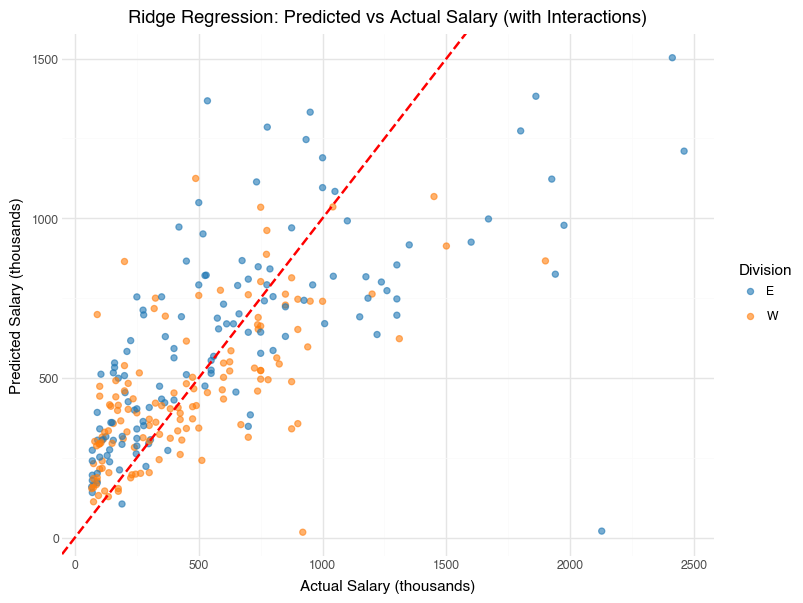

In [ ]:
# Prepare data for plotting
df_plot = pd.DataFrame({
    'Actual_Salary': y,
    'Predicted_Salary': y_pred,
    'Division': X['Division']
})

# Plot
plot = (
    p9.ggplot(df_plot, p9.aes(x='Actual_Salary', y='Predicted_Salary'))
    + p9.geom_point(p9.aes(color='Division'), alpha=0.6, size=2)
    + p9.geom_abline(intercept=0, slope=1, color='red', linetype='dashed', size=1)
    + p9.labs(
        title='Ridge Regression: Predicted vs Actual Salary (with Interactions)',
        x='Actual Salary (thousands)',
        y='Predicted Salary (thousands)'
    )
    + p9.scale_color_manual(values=['#1f77b4', '#ff7f0e'])
    + p9.theme_minimal()
    + p9.theme(figure_size=(8, 6))
)

plot

While visually the regression line seems to decently represent the data the final R² Score: 0.462072 shows that there is a lot of room left for improvement. Likely this model would benefit from further exploration of quadraic, exponential, or log models. 